# Validation of Jutul against existing reservoir simulators
This example contains validation of Jutul against [MRST](https://www.mrst.no).
In general, minor differences are observed. These can be traced back to a
combination of different internal timestepping done by the simulators and that
JutulDarcy by default uses a multisegment well formulation while MRST uses a
standard instantaneous equilibrium model without well bore storage terms.
These differences are most evident when simulators start up.

These cases have been exported using the MRST `jutul` module which can export
MRST or Eclipse-type of cases to a JutulDarcy-compatible input format. They
can then be simulated using `simulate_mrst_case`.

In [1]:
using JutulDarcy, Jutul
using GLMakie

## Define a few utilities for plotting the MRST results
We are going to compare well responses against pre-computed results stored
inside the JutulDarcy module.

In [2]:
function mrst_case_path(name)
    base_path, = splitdir(pathof(JutulDarcy))
    joinpath(base_path, "..", "test", "mrst", "$(name).mat")
end

function mrst_solution(result)
    return result.extra[:mrst]["extra"][1]["mrst_solution"]
end

function mrst_well_index(mrst_result, k)
    return findfirst(isequal("$k"), vec(mrst_result["names"]))
end

function get_mrst_comparison(wdata, ref, wname, t = :bhp)
    yscale = "m³/s"
    if t == :bhp
        tname = :bhp
        mname = "bhp"
        yscale = "Pa"
    elseif t == :qos
        tname = :orat
        mname = "qOs"
    elseif t == :qws
        tname = :wrat
        mname = "qWs"
    elseif t == :qgs
        tname = :grat
        mname = "qGs"
    else
        error("Not supported: $t")
    end
    jutul = wdata[tname]
    mrst = ref[mname][:, mrst_well_index(ref, wname)]

    return (jutul, mrst, tname, yscale)
end

function plot_comparison(wsol, ref, rep_t, t, wells_keys = keys(wsol.wells))
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel = "time (days)")
    l = ""
    yscale = ""
    T = rep_t./(3600*24.0)
    for (w, d) in wsol.wells
        if !(w in wells_keys)
            continue
        end
        jutul, mrst, l, yscale = get_mrst_comparison(d, ref, w, t)
        lines!(ax, T, abs.(jutul), label = "$w")
        scatter!(ax, T, abs.(mrst), markersize = 8)
    end
    axislegend()
    ax.ylabel[] = "$l ($yscale)"
    fig
end

plot_comparison (generic function with 2 methods)

## The Egg model (oil-water compressible)
A two-phase model that is taken from the first member of the EGG ensemble. For
more details, see the paper where the ensemble is introduced:

[Jansen, Jan-Dirk, et al. "The egg model–a geological ensemble for reservoir
simulation." Geoscience Data Journal 1.2 (2014): 192-195.](https://doi.org/10.1002/gdj3.21)

### Simulate model

In [3]:
egg = simulate_mrst_case(mrst_case_path("egg"), info_level = -1)
wells = egg.wells
rep_t = egg.time
ref = mrst_solution(egg);

MRST model: Reading input file /home/runner/work/JutulDarcy.jl/JutulDarcy.jl/src/../test/mrst/egg.mat.
[ Info: This is the first call to simulate_mrst_case. Compilation may take some time...
MRST model: Starting simulation of immiscible system with 18553 cells and 2 phases and 2 components.
MRST model: Model was successfully simulated.


### Compare well responses

In [4]:
injectors = [:INJECT1, :INJECT2, :INJECT3, :INJECT4, :INJECT5, :INJECT6, :INJECT7]
producers = [:PROD1, :PROD2, :PROD3, :PROD4]

4-element Vector{Symbol}:
 :PROD1
 :PROD2
 :PROD3
 :PROD4

#### Bottom hole pressures

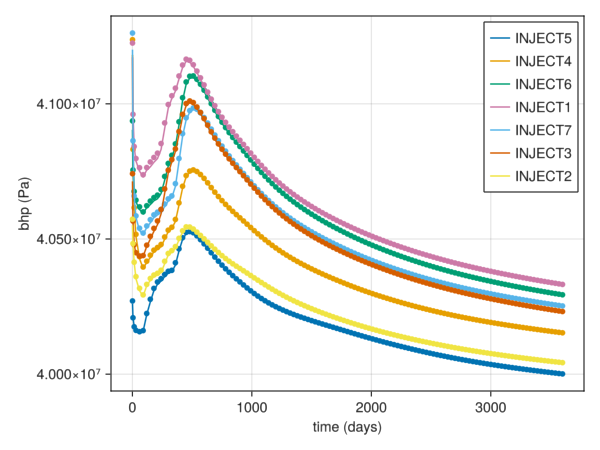

In [5]:
plot_comparison(wells, ref, rep_t, :bhp, injectors)

#### Oil rates

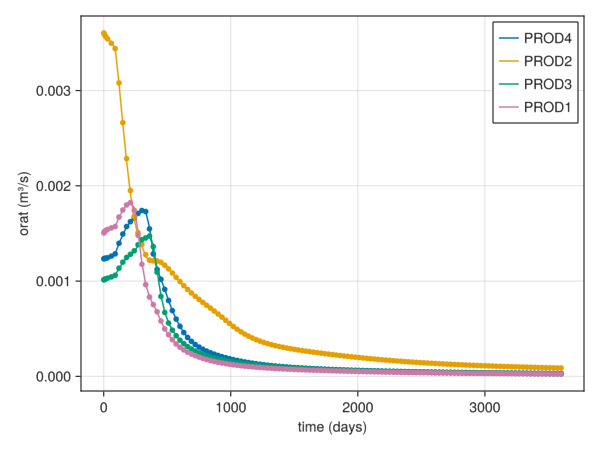

In [6]:
plot_comparison(wells, ref, rep_t, :qos, producers)

#### Water rates

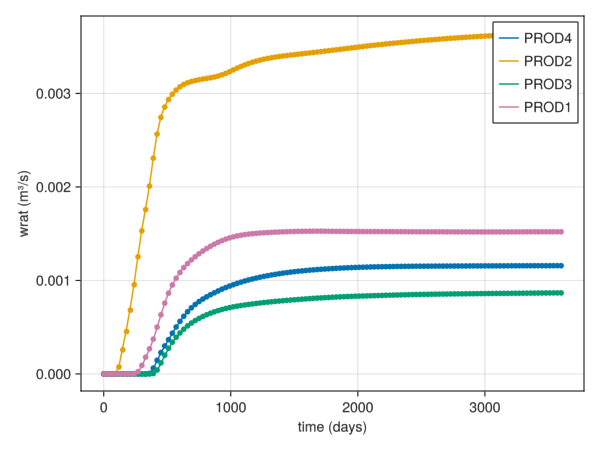

In [7]:
plot_comparison(wells, ref, rep_t, :qws, producers)

## SPE1 (black oil, disgas)
A shortened version of the SPE1 benchmark case.

[Odeh, A.S. 1981. Comparison of Solutions to a Three-Dimensional Black-Oil
Reservoir Simulation Problem. J Pet Technol 33 (1): 13–25.
SPE-9723-PA](http://dx.doi.org/10.2118/9723-PA)

For comparison against other simulators, see the equivialent JutulSPE1 example
in the Jutul module for [MRST](https://www.mrst.no)
### Simulate model

In [8]:
spe1 = simulate_mrst_case(mrst_case_path("spe1"), info_level = -1)
wells = spe1.wells
rep_t = spe1.time
ref = mrst_solution(spe1);

MRST model: Reading input file /home/runner/work/JutulDarcy.jl/JutulDarcy.jl/src/../test/mrst/spe1.mat.
[ Info: This is the first call to simulate_mrst_case. Compilation may take some time...
MRST model: Starting simulation of black-oil system with 300 cells and 3 phases and 3 components.
MRST model: Model was successfully simulated.


### Compare well responses
#### Bottom hole pressures

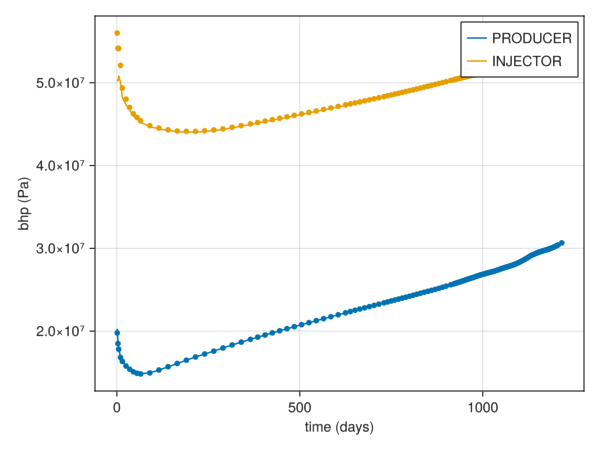

In [9]:
plot_comparison(wells, ref, rep_t, :bhp)

#### Gas rates

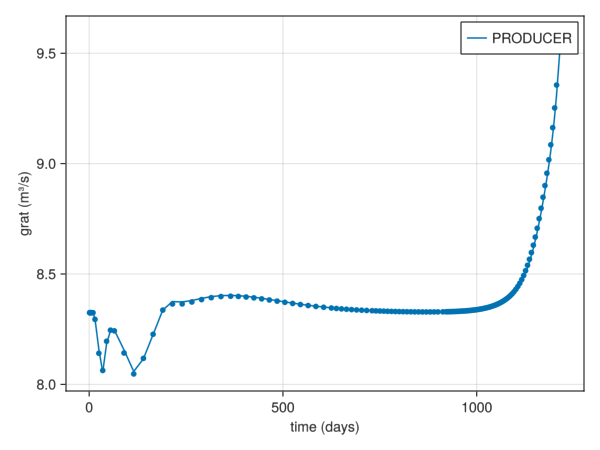

In [10]:
plot_comparison(wells, ref, rep_t, :qgs, [:PRODUCER])

## SPE3 (black oil, vapoil)
A black-oil variant of the SPE3 benchmark case.

[Kenyon, D. "Third SPE comparative solution project: gas cycling of retrograde
condensate reservoirs." Journal of Petroleum Technology 39.08 (1987):
981-997](http://dx.doi.org/10.2118/12278-PA)

### Simulate model

In [11]:
spe3 = simulate_mrst_case(mrst_case_path("spe3"), info_level = -1)
wells = spe3.wells
rep_t = spe3.time
ref = mrst_solution(spe3);

MRST model: Reading input file /home/runner/work/JutulDarcy.jl/JutulDarcy.jl/src/../test/mrst/spe3.mat.
[ Info: This is the first call to simulate_mrst_case. Compilation may take some time...
MRST model: Starting simulation of black-oil system with 324 cells and 3 phases and 3 components.
MRST model: Model was successfully simulated.


### Compare well responses
#### Bottom hole pressures

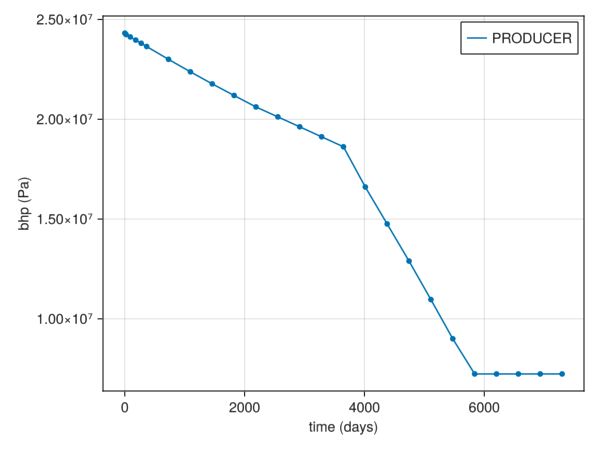

In [12]:
plot_comparison(wells, ref, rep_t, :bhp, [:PRODUCER])

#### Gas rates

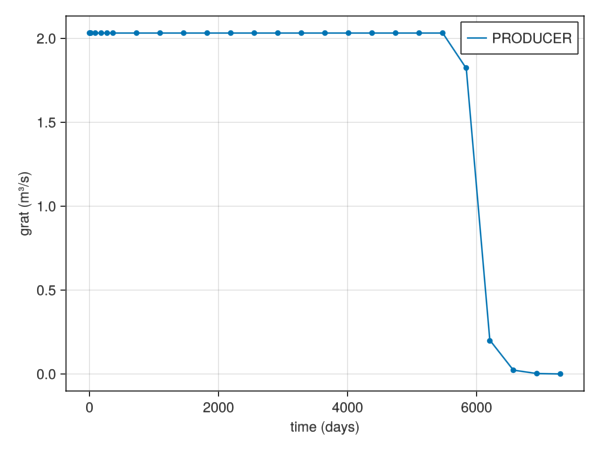

In [13]:
plot_comparison(wells, ref, rep_t, :qgs, [:PRODUCER])

#### Oil rates

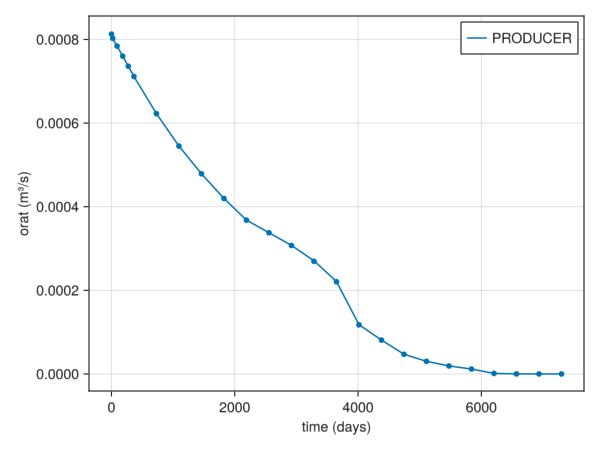

In [14]:
plot_comparison(wells, ref, rep_t, :qos, [:PRODUCER])

## SPE9 (black oil, disgas)
Example of the SPE9 model exported from MRST running in JutulDarcy.

  [Killough, J. E. 1995. Ninth SPE comparative solution project: A
  reexamination of black-oil simulation. In SPE Reservoir Simulation
  Symposium,  12-15 February 1995, San Antonio, Texas. SPE 29110-MS]
  (http://dx.doi.org/10.2118/29110-MS)

For comparison against other simulators, see the equivialent JutulSPE9 example
in the Jutul module for [MRST](https://www.mrst.no)

### Simulate model

In [15]:
spe9 = simulate_mrst_case(mrst_case_path("spe9"), info_level = -1)
wells = spe9.wells
rep_t = spe9.time
ref = mrst_solution(spe9);

MRST model: Reading input file /home/runner/work/JutulDarcy.jl/JutulDarcy.jl/src/../test/mrst/spe9.mat.
[ Info: This is the first call to simulate_mrst_case. Compilation may take some time...
MRST model: Starting simulation of black-oil system with 9000 cells and 3 phases and 3 components.
MRST model: Model was successfully simulated.


### Compare well responses

In [16]:
injectors = [:INJE1]
producers = [Symbol("PROD$i") for i in 1:25]

25-element Vector{Symbol}:
 :PROD1
 :PROD2
 :PROD3
 :PROD4
 :PROD5
 :PROD6
 :PROD7
 :PROD8
 :PROD9
 :PROD10
 ⋮
 :PROD17
 :PROD18
 :PROD19
 :PROD20
 :PROD21
 :PROD22
 :PROD23
 :PROD24
 :PROD25

#### Injector water rate

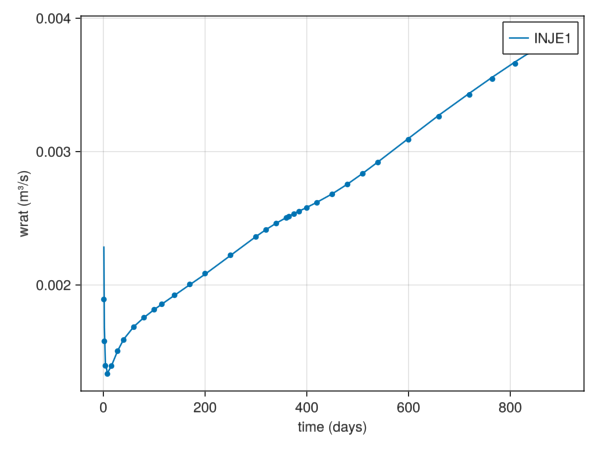

In [17]:
plot_comparison(wells, ref, rep_t, :qws, injectors)

#### Oil rates

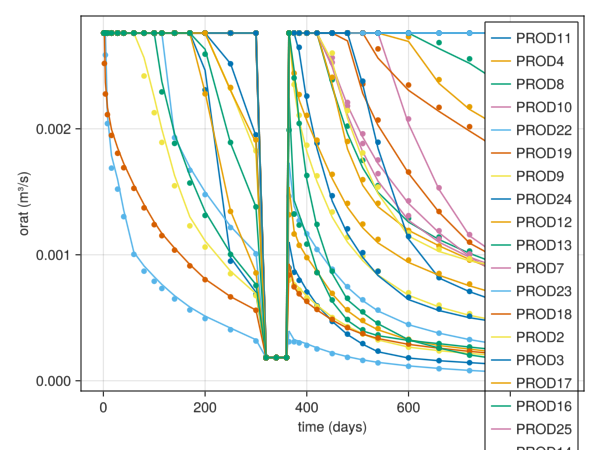

In [18]:
plot_comparison(wells, ref, rep_t, :qos, producers)

#### Water rates

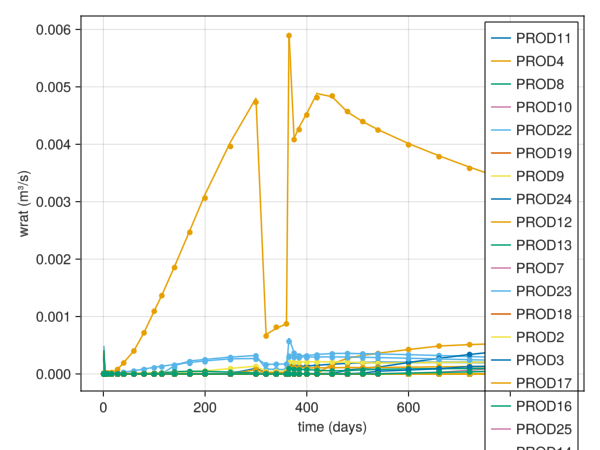

In [19]:
plot_comparison(wells, ref, rep_t, :qws, producers)

#### Bottom hole pressures

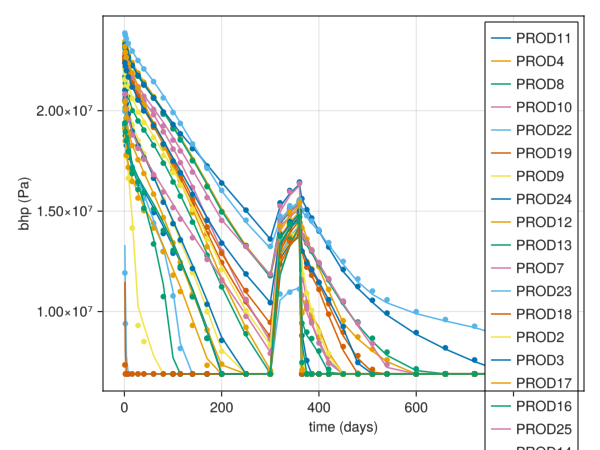

In [20]:
plot_comparison(wells, ref, rep_t, :bhp, producers)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*